# Computer Vision - Project 2

### Description

The system recognizes the state of gameplay from a movie (in the selected board game). 

The program tracks the movement of dice and tokens; detects events in the film.

### The input data is divided into 3 groups depending on the difficulty:

- easy: perfect view, the game elements are not covered with your hands when carrying it;

-medium: different dynamics of light in the picture, shadows, light reflections;

- difficult: angled view, game components partially covered with hands when moving, slight shaking of the camera.


# Team members

- Sofya Aksenyuk, 150284

- Uladzimir Ivashka, 150281

# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

# Prerequirements

In [2]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
folders_required = ['clipped', 'track', 'templates', 'templates/difficult', 'templates/difficult/static', 'templates/difficult/track']

for folder in folders_required:
  if not os.path.exists(folder):
    os.mkdir(folder)

# Visualization functions

In [4]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [5]:
def get_coords(bbox):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  return p1, p2


def draw_bbox(frame, bbox, color=(255, 0, 0), thickness=2):
  p1, p2 = get_coords(bbox)
  cv2.rectangle(frame, p1, p2, color, thickness, 1)

In [6]:
def get_token_center(bbox):
    p1, p2 = get_coords(bbox)
    center = (p2[0] - p1[0]) // 2
    return p1[0] + center, p2[1] - 5

In [7]:
def get_center(bbox):
    p1, p2 = get_coords(bbox)
    center = (p2[0] - p1[0]) // 2
    return p1[0] + center, p1[1] + center

## Stabilize video


In [8]:
def stabilize(path):

  def moving_average(curve, radius): 
    window_size = 2 * radius + 1
    f = np.ones(window_size)/window_size 
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge') 
    curve_smoothed = np.convolve(curve_pad, f, mode='same') 
    curve_smoothed = curve_smoothed[radius:-radius]

    return curve_smoothed 

  def smooth(trajectory): 
    smoothed_trajectory = np.copy(trajectory) 
    for i in range(3):
      smoothed_trajectory[:,i] = moving_average(trajectory[:,i], radius=SMOOTHING_RADIUS)

    return smoothed_trajectory

  def fix_border(frame):
    s = frame.shape
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))

    return frame


  SMOOTHING_RADIUS=50 

  cap = cv2.VideoCapture(path) 

  n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 

  w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
  h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  fps = cap.get(cv2.CAP_PROP_FPS)

  fourcc = cv2.VideoWriter_fourcc(*'DIVX')

  out = cv2.VideoWriter('video_out.avi', fourcc, fps, (w, h))

  _, prev = cap.read() 

  prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

  transforms = np.zeros((n_frames-1, 3), np.float32) 

  for i in range(n_frames-2):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                      maxCorners=200,
                                      qualityLevel=0.01,
                                      minDistance=30,
                                      blockSize=3)
    
    success, curr = cap.read() 
    if not success: 
      break 

    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 

    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

    assert prev_pts.shape == curr_pts.shape 

    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    m, _ = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
    dx = m[0,2]
    dy = m[1,2]

    da = np.arctan2(m[1,0], m[0,0])

    transforms[i] = [dx,dy,da]

    prev_gray = curr_gray

  trajectory = np.cumsum(transforms, axis=0) 

  smoothed_trajectory = smooth(trajectory) 

  difference = smoothed_trajectory - trajectory

  transforms_smooth = transforms + difference

  cap.set(cv2.CAP_PROP_POS_FRAMES, 0) 
  
  for i in range(n_frames-2):
    success, frame = cap.read() 
    if not success:
      break

    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]

    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    frame_stabilized = cv2.warpAffine(frame, m, (w,h))

    frame_stabilized = fix_border(frame_stabilized)
    
    out.write(frame_stabilized)

  cap.release()
  out.release()

# Difficult Dataset

In [9]:
# !gdown 15vYTnaqatmokAOwwpjycPZsMqr8txcss
# !unzip dataset-difficult-final.zip

In [10]:
!gdown 1TyeWG8nyUDOPHTCOwhfH58iWOe53y2Tm
!unzip check.zip

Downloading...
From: https://drive.google.com/uc?id=1TyeWG8nyUDOPHTCOwhfH58iWOe53y2Tm
To: /content/check.zip
100% 71.8M/71.8M [00:01<00:00, 44.3MB/s]
Archive:  check.zip
  inflating: check/difficult.mp4     


In [11]:
# stabilize('./dataset-difficult-final/difficult.mp4')
# !ffmpeg -hide_banner -loglevel error -i ./video_out.avi -y ./difficult_stabilized.mp4
stabilize('./check/difficult.mp4')
!ffmpeg -hide_banner -loglevel error -i ./video_out.avi -y ./difficult_stabilized.mp4

In [12]:
def read_video(path):
  video = cv2.VideoCapture(path)
  if not video.isOpened():
    assert("Cannot open video")

  video_width = int(video.get(3))
  video_height = int(video.get(4))
  print(f'Video resolution: {video_height}x{video_width}')

  video_fps = video.get(cv2.CAP_PROP_FPS)
  print(f'Video fps: {video_fps}')

  return video, video_width, video_height, video_fps

In [13]:
def create_templates(frame, bboxes_static, bboxes_track, path):

  for name, bbox in bboxes_static.items():
    p1, p2 = get_coords(bbox)
    template = frame[p1[1]:p2[1], p1[0]:p2[0]]
    cv2.imwrite(f'{path}/static/{name}.png', template)
  
  for name, bbox in bboxes_track.items():
    p1, p2 = get_coords(bbox)
    template = frame[p1[1]:p2[1], p1[0]:p2[0]]
    cv2.imwrite(f'{path}/track/{name}.png', template)

## Translate angle videoframe

In [14]:
def translate_view(frame):
  mtx = np.array([[894.96803896,0,470.38713516],[0,901.32629374,922.41232898], [0,0,1]])
  dist = np.array([[-0.3,0.15,0,0,-0.035]])
  newcameramtx = np.array([[894.96803896,0,400.38713516],[325,751.32629374,950.41232898], [0.4,0.3,1]])
  
  return cv2.undistort(frame, mtx, dist, None, newcameramtx)

## Creating templates

Video resolution: 720x1280
Video fps: 30.0

First frame with bboxes:


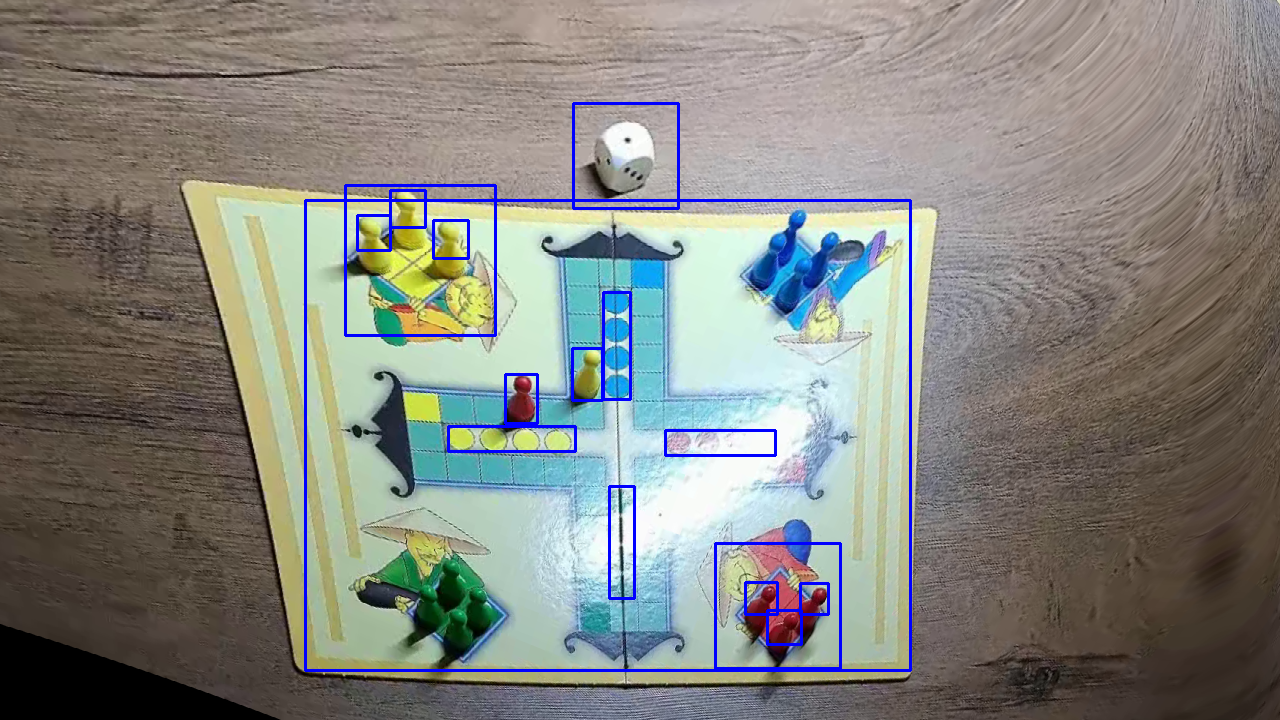

In [15]:
difficult = read_video('difficult_stabilized.mp4')[0]
ret, frame = difficult.read()
frame = translate_view(frame)

bboxes_static = dict()
bboxes_track = dict()

## static bboxes
board_bbox = (305, 200, 605, 470)
bboxes_static["board_bbox"] = board_bbox

yellow_home_bbox = (448, 426, 127, 25)
bboxes_static["yellow_home_bbox"] = yellow_home_bbox

red_home_bbox = (665, 430, 110, 25)
bboxes_static["red_home_bbox"] = red_home_bbox

green_home_bbox = (609, 486, 25, 112)
bboxes_static["green_home_bbox"] = green_home_bbox

blue_home_bbox = (603, 292, 27, 107)
bboxes_static["blue_home_bbox"] = blue_home_bbox

yellow_yard_bbox = (345, 185, 150, 150)
bboxes_static["yellow_yard_bbox"] = yellow_yard_bbox

red_yard_bbox = (715, 543, 125, 125)
bboxes_static["red_yard_bbox"] = red_yard_bbox

## bboxes to track
dice_bbox = (573, 103, 105, 105)
bboxes_track["dice_bbox"] = dice_bbox

yellow_bbox1 = (572, 348, 30, 52)
bboxes_track["yellow_bbox1"] = yellow_bbox1

yellow_bbox2 = (357, 215, 33, 35)
bboxes_static["yellow_bbox2"] = yellow_bbox2

yellow_bbox3 = (390, 190, 35, 37)
bboxes_static["yellow_bbox3"] = yellow_bbox3

yellow_bbox4 = (433, 220, 35, 38)
bboxes_static["yellow_bbox4"] = yellow_bbox4

red_bbox1 = (505, 374, 32, 49)
bboxes_track["red_bbox1"] = red_bbox1

red_bbox2 = (745, 582, 32, 32)
bboxes_static["red_bbox2"] = red_bbox2

red_bbox3 = (800, 583, 28, 31)
bboxes_static["red_bbox3"] = red_bbox3

red_bbox4 = (767, 610, 34, 34)
bboxes_static["red_bbox4"] = red_bbox4

create_templates(frame, bboxes_static, bboxes_track, './templates/difficult')

## showing results
for bbox in bboxes_static.values():
  draw_bbox(frame, bbox, (255, 0, 0), 2)
  
for bbox in bboxes_track.values():
  draw_bbox(frame, bbox, (255, 0, 0), 2)

print(f'\nFirst frame with bboxes:')
imshow(frame)

# Tracking

In [16]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.legacy.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.legacy.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.legacy.TrackerCSRT_create()

## Difficult dataset

### Read video and find objects from templates

Video resolution: 720x1280
Video fps: 30.0

First frame with detected objects from templates:


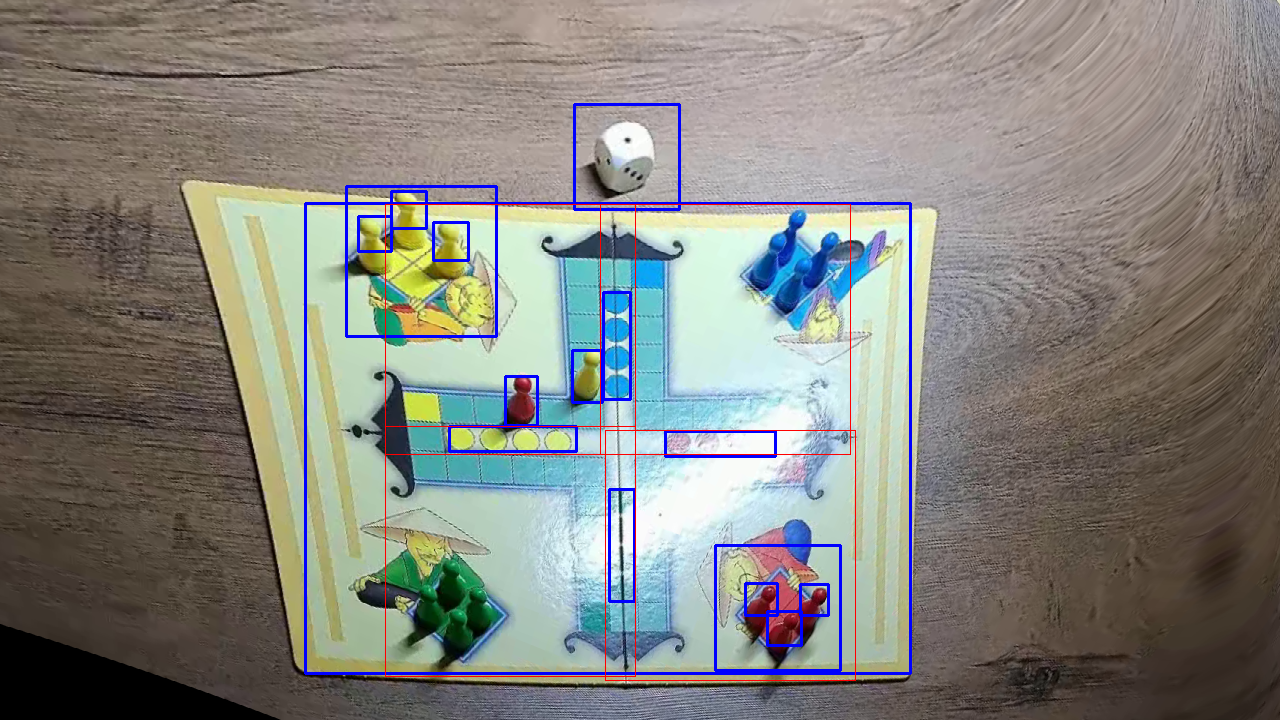

In [36]:
## templates matching
difficult, difficult_width, difficult_height, difficult_fps = read_video('./difficult_stabilized.mp4')
ret, frame = difficult.read()
frame = translate_view(frame)
bboxes_static = dict()
bboxes_track = dict()

for _file in glob.glob('./templates/difficult/static/*'):
  template = cv2.imread(_file, cv2.IMREAD_COLOR)
  _, w, h = template.shape[::-1]
  res = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
  loc = np.where(res >= 0.9)
  for pt in zip(*loc[::-1]):
    p1, p2 = pt, (pt[0] + w, pt[1] + h)
    bboxes_static[os.path.basename(_file).split('.')[0]] = (p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1])

for _file in glob.glob('./templates/difficult/track/*'):
  template = cv2.imread(_file, cv2.IMREAD_COLOR)
  _, w, h = template.shape[::-1]
  res = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
  loc = np.where(res >= 0.9)
  for pt in zip(*loc[::-1]):
    p1, p2 = pt, (pt[0] + w, pt[1] + h)
    bboxes_track[os.path.basename(_file).split('.')[0]] = (p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1])

## dividing board to 4 parts
box_parts = {}

left_up_bbox = (385, 204, 250, 250)
box_parts["left_up_bbox"] = left_up_bbox

right_up_bbox = (600, 204, 250, 250)
box_parts["right_up_bbox"] = right_up_bbox

right_down_bbox = (605, 430, 250, 250)
box_parts["right_down_bbox"] = right_down_bbox

left_down_bbox = (385, 426, 250, 250)
box_parts["left_down_bbox"] = left_down_bbox

## compute intersection points
int_points = {}
CELL_SIZE = 32

top = (334, 307, CELL_SIZE, CELL_SIZE)
int_points["up"] = get_center(top)

right = (546, 527, CELL_SIZE, CELL_SIZE)
int_points["right"] = get_center(right)

down = (330, 740, CELL_SIZE, CELL_SIZE)
int_points["down"] = get_center(down)

left = (116, 522, CELL_SIZE, CELL_SIZE)
int_points["left"] = get_center(left)

## showing results
for bbox in bboxes_static.values():
  draw_bbox(frame, bbox, (255, 0, 0), 2)
  
for bbox in bboxes_track.values():
  draw_bbox(frame, bbox, (255, 0, 0), 2)

for bbox in box_parts.values():
  draw_bbox(frame, bbox, (0, 0, 255), 1)

print(f'\nFirst frame with detected objects from templates:')
imshow(frame)

In [41]:
def detect_templates(frame):
  bboxes_static = dict()

  for _file in glob.glob('./templates/difficult/static/*'):
    bboxes_static[_file.split('/')[-1].split('.')[0]] = match_template(frame, _file)

  return bboxes_static


def match_template(frame, name):
  MIN_MATCH_COUNT = 10

  template_image = cv2.imread(name)
  template_image_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()

  kp_template, des_template = sift.detectAndCompute(template_image_gray, None)

  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)

  flann = cv2.FlannBasedMatcher(index_params, search_params)

  img = frame.copy() 

  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  kp_img, des_img = sift.detectAndCompute(img, None)

  img_height, img_width = img_gray.shape

  matches = flann.knnMatch(des_template,des_img,k=2)

  good = []
  for m,n in matches:
      if m.distance < 0.7*n.distance:
          good.append(m)


  if len(good)>MIN_MATCH_COUNT:
      src_pts = np.float32([ kp_template[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp_img[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
      matchesMask = mask.ravel().tolist()

      h,w = template_image_gray.shape
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      try: 
        dst = cv2.perspectiveTransform(pts,M)
      except:
        return None

      img_board = img.copy()
      cv2.polylines(img_board,[np.int32(dst)],True,255,10, cv2.LINE_AA)

      x,y,w,h = cv2.boundingRect(dst)

      return (x, y, w, h)

In [19]:
def is_in_bbox(static_bbox, track_bbox):

  center = get_token_center(track_bbox)
  p1, p2 = get_coords(static_bbox)

  if p1[0] <= center[0] <= p2[0] and p1[1] <= center[1] <= p2[1]:
    return True
    
  return False

In [20]:
def get_stats(frame, boxes, bboxes_static):
  yellow_home, red_home = bboxes_static['yellow_home_bbox'], bboxes_static['red_home_bbox']
  yellow_yard, red_yard = bboxes_static['yellow_yard_bbox'], bboxes_static['red_yard_bbox']
  yard_tokens = [bboxes_static[f'{y}_bbox{x}'] for x in range(2, 5) for y in ['red', 'yellow']]

  yellow_score, red_score = 0, 0
  yellow_tokens, red_tokens = 0, 0

  for token in list(boxes)+yard_tokens:
    if is_in_bbox(yellow_home, token):
      yellow_score += 1
    if is_in_bbox(red_home, token):
      red_score += 1

    if is_in_bbox(yellow_yard, token):
      yellow_tokens += 1
    if is_in_bbox(red_yard, token):
      red_tokens += 1

  return yellow_score, yellow_tokens, red_score, red_tokens

In [21]:
def get_dice_dots(frame, dice_box):
  p1, p2 = get_coords(dice_box)
  dice = frame[p1[1]:p2[1], p1[0]:p2[0]]
  if not len(dice) or dice is None:
    return 'no info'

  dots = cv2.cvtColor(dice, cv2.COLOR_BGR2GRAY)
  dots = cv2.GaussianBlur(dots, (3, 3), 0)
  dots = cv2.threshold(dots, 210, 255, cv2.THRESH_BINARY)[1]
  dots = cv2.dilate(dots, np.ones((2,2)), 1)

  circles = cv2.HoughCircles(dots, cv2.HOUGH_GRADIENT, 1, 3, param1=100, param2=5, minRadius=2, maxRadius=3)

  if circles is None:
    return 'no info'
  else:
    return len(circles[0])

In [22]:
def manhattan_distance(point1, point2):
    return sum(abs(value1 - value2) for value1, value2 in zip(point1, point2)) / 32


def token_distance(yellow_boxes, red_boxes, bboxes_static, box_parts):
  distances = {}
  yellow, red = None, None
  flag = True

  for yellow_box in yellow_boxes:
    if (not is_in_bbox(bboxes_static['yellow_yard_bbox'], yellow_box)) and (not is_in_bbox(bboxes_static['yellow_home_bbox'], yellow_box)):

      for red_box in red_boxes:
        if (not is_in_bbox(bboxes_static['red_yard_bbox'], red_box)) and (not is_in_bbox(bboxes_static['red_home_bbox'], red_box)):

          for name, part in box_parts.items():
            
            if is_in_bbox(part, red_box) and is_in_bbox(part, yellow_box):
              distances[tuple(red_box)] = manhattan_distance(get_token_center(red_box), get_token_center(yellow_box))
              flag = False

            if is_in_bbox(part, red_box):
              red = name
            if is_in_bbox(part, yellow_box):
              yellow = name

          if flag and (not yellow is None) and (not red is None):
            order = tuple(sorted([yellow, red]))
            for inst in dist_instructions[order]:

              if len(inst) == 1:
                distances[tuple(red_box)] = manhattan_distance(get_token_center(red_box), inst[0]) +  manhattan_distance(get_center(yellow_box), inst[0])

              if len(inst) == 2:
                if order[0] == yellow:
                  distances[tuple(red_box)] = manhattan_distance(get_token_center(yellow_box), inst[0]) + DIST_CONST + manhattan_distance(get_center(red_box), inst[1])
                else:
                  distances[tuple(red_box)] = manhattan_distance(get_token_center(yellow_box), inst[1]) + DIST_CONST + manhattan_distance(get_center(red_box), inst[0])

          yellow, red = None, None
          flag = True

  if distances:
    distances = sorted(distances.items(), key=lambda x: x[1])[0]
    return distances[0], distances[1]
  return None, 'no info'

In [23]:
## instructions for computing distance
dist_instructions = {}
dist_instructions[('left_down_bbox', 'left_up_bbox')] = [[int_points['left']]]
dist_instructions[('left_down_bbox', 'right_down_bbox')] = [[int_points['down']]]
dist_instructions[('left_down_bbox', 'right_up_bbox')] = [[int_points['left'], int_points['up']], [int_points['right'], int_points['down']]]
dist_instructions[('left_up_bbox', 'right_down_bbox')] = [[int_points['up'], int_points['right']], [int_points['down'], int_points['left']]]
dist_instructions[('left_up_bbox', 'right_up_bbox')] = [[int_points['up']]]
dist_instructions[('right_down_bbox', 'right_up_bbox')] = [[int_points['right']]]
DIST_CONST = round(manhattan_distance(int_points['left'], int_points['up']) / 32)

### Track objects

In [42]:
difficult.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = difficult.read()
frame = translate_view(frame)

yellow_multiTracker = cv2.legacy.MultiTracker_create()
red_multiTracker = cv2.legacy.MultiTracker_create()
dice_tracker = create_tracker("KCF")

for name, bbox in bboxes_track.items():
  if name == 'dice_bbox':
    dice_tracker.init(frame, bbox)
  if name.split('_')[0] == 'yellow':
    yellow_multiTracker.add(create_tracker("CSRT"), frame, bbox)
  if name.split('_')[0] == 'red':
    red_multiTracker.add(create_tracker("CSRT"), frame, bbox)

In [43]:
difficult_track = cv2.VideoWriter('./track/difficult_track.avi', cv2.VideoWriter_fourcc(*'DIVX'), difficult_fps, (difficult_width, difficult_height))
difficult.set(cv2.CAP_PROP_POS_FRAMES, 0)

_yellow_tokens, _red_tokens = 9, 9
counter = 0
pos_rip = (99999, 99999)
while difficult.isOpened():
  success, frame = difficult.read()
  if not success:
    break
  frame = translate_view(frame)  

  _, yellow_boxes = yellow_multiTracker.update(frame)
  _, red_boxes = red_multiTracker.update(frame)
  _, dice_box = dice_tracker.update(frame)

  bboxes_static_det = detect_templates(frame)

  for key, value in bboxes_static_det.items():
    if not value is None:
      bboxes_static[key] = bboxes_static_det[key]

  for bbox in bboxes_static.values():
    draw_bbox(frame, bbox, (0, 0, 255), 2)
 
  for newbox in yellow_boxes:
    draw_bbox(frame, newbox, (0, 0, 255), 2)

  for newbox in red_boxes:
    draw_bbox(frame, newbox, (0, 0, 255), 2)

  yellow_score, yellow_tokens, red_score, red_tokens = get_stats(frame, np.concatenate([yellow_boxes,red_boxes]), bboxes_static)
  frame = cv2.putText(frame, f'yellow tokens in yard: {yellow_tokens}', (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
  frame = cv2.putText(frame, f'red tokens in yard: {red_tokens}', (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
  frame = cv2.putText(frame, f'yellow score: {yellow_score}', (1030, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
  frame = cv2.putText(frame, f'red score: {red_score}', (1030, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

  draw_bbox(frame, dice_box, (0, 255, 0), 3)
  dice_dots = get_dice_dots(frame, dice_box)
  p1, p2 = get_coords(dice_box)
  pos = (p2[0] + 10, (p1[1] + p2[1]) // 2 + 20)
  frame = cv2.putText(frame, f'{dice_dots}', pos, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

  pos, dist = token_distance(yellow_boxes, red_boxes, bboxes_static, box_parts)
  dist_round = dist
  if isinstance(dist, float) or isinstance(dist, int):
    dist_round = round(dist)
    if dist <= 6:
      frame = cv2.putText(frame, f'Danger!', (1000, 600), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3, cv2.LINE_AA)
  
  frame = cv2.putText(frame, f'min dist between opponents: {dist_round}', (750, 710), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

  if counter <= 0 and isinstance(dist, float) and dist < 0.92:
    pos_rip = (int(pos[0]), int(pos[1]) - 20)
    counter = 60
  if counter > 0:
    frame = cv2.putText(frame, f'token rip', pos_rip, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    counter -= 1

  difficult_track.write(frame)

difficult_track.release()

In [44]:
!ffmpeg -hide_banner -loglevel error -i ./track/difficult_track.avi -y ./track/difficult_track.mp4